<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/master/Notebook_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Notebook : Création des modèles GAN, AE et VAE </H1>

Bienvenue dans ce notebook dédié à l'exploration en profondeur des générateurs adverses (GANs), des autoencodeurs (AEs) et des autoencodeurs variationnels (VAEs). Les GANs, conceptualisés par Ian Goodfellow et ses collègues en 2014, ont révolutionné la génération de données en introduisant un cadre d'entraînement basé sur la compétition entre un générateur et un discriminateur. Ils ont permis de créer des données synthétiques d'une qualité inégalée, propulsant ainsi des avancées majeures dans des domaines tels que la génération d'images photoréalistes et la synthèse de vidéos. Les autoencodeurs (AE), quant à eux, ont ouvert la voie à des techniques de compression de données innovantes en apprenant à représenter de manière compacte l'information essentielle d'une donnée tout en minimisant la perte d'information. Ils ont été largement utilisés pour des tâches de débruitage, de reconstruction, et de réduction de dimensionnalité. Les autoencodeurs variationnels (VAEs) ont apporté une dimension probabiliste à l'apprentissage de représentations. Ils ont la capacité unique de générer de nouvelles données en explorant un espace latent continu. Cette approche probabiliste a ouvert de nouvelles perspectives dans la génération de données avec une contrôlabilité fine.

Dans ce notebook avancé, nous plongerons profondément dans ces trois paradigmes, explorant leurs mécanismes internes, leurs architectures avancées, ainsi que leurs applications de pointe. Nous discuterons également des défis et des limites actuelles de ces techniques et des pistes de recherche futures.

*Note à moi-même : putain j'ai pas envie de le faire celui-la, ca va être longue...*

GAN :

https://www.tensorflow.org/tutorials/generative/dcgan?hl=fr

https://github.com/heykeetae/Self-Attention-GAN/tree/master

https://github.com/yaxingwang/MineGAN/tree/master/styleGANv2

https://github.com/yaxingwang/Transferring-GANs

AE :

https://www.kaggle.com/code/ritvik1909/autoencoders-for-transfer-learning

VAE :

https://github.com/hsinyilin19/ResNetVAE

# Installation

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jy03njht
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-jy03njht
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import random
import shutil
import keras
import imageio
import glob
import pathlib
import sys
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
from numpy import mean
from numpy import std
from keras import backend as K
from IPython import display
import matplotlib.cm as cm
import tensorflow as tf
from numpy import ones, zeros
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from numpy.random import randint
from tensorflow.keras.regularizers import L1L2
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, Lion
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Dense, GlobalAveragePooling2D, Reshape, Flatten, Rescaling, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, LeakyReLU

In [ ]:
# GLOBAL VARIABLE
IMG_SIZE = 128
BATCH_SIZE = 4
CHANEL = 3
IMG_SHAPE=(IMG_SIZE, IMG_SIZE, CHANEL)
EPOCHS = 1000
VERBOSE = 1
COLUMNS = 25
SEED = 123
PATH_DIR = "/content/gdrive/MyDrive/Colab_Notebooks/HAI923/Tiger-Fox-Elephant/"
POLICE_SIZE = 18 # Taille de la police pour les plot
plt.rcParams.update({'font.size': POLICE_SIZE})

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/MyDrive/Colab Notebooks/HAI923/
path = %pwd
%mkdir Résultats/GAN

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/HAI923
mkdir: cannot create directory ‘Résultats/GAN’: File exists


# Model

## GAN

In [ ]:
def create_generator():
  epsilon = 0.0001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
  noise_shape = (100,)
  size = int(IMG_SIZE/(32*2))
  model = Sequential()

  # Définition des couches de Convolution/Pooling
  model.add(Dense(size*size*512*2, activation='linear', input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((size, size, 512*2)))

  model.add(Conv2DTranspose(512*2, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(256*2, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128*2, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(64*2, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(32, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [ ]:
def create_discriminator():
  model = Sequential()

  # Définition des couches de Convolution/Pooling
  model.add(Conv2D(2*128, (3,3), padding='same', input_shape=[IMG_SIZE,IMG_SIZE,3]))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))
  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))
  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))
  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(2*128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))

  # Flattening : passage de matrices 3D vers un vecteur
  model.add(Flatten())
  model.add(Dense(2*128))
  model.add(LeakyReLU(alpha=0.2))

  # Couche de sortie : classification => binaire : 1 -> vraie image, 0 -> fausse image
  model.add(Dense(2*128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  # compilation du  modèle de classification
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
"""
def create_generator(latent_dim=100) :
  epsilon = 0.0001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
  noise_shape = (100,)
  size = int(IMG_SIZE/(16)) # DENSE : 512 => 32 / DENSE : 1024 => 64
  model = Sequential()

  # Définition des couches de Convolution/Pooling
  model.add(Dense(size*size*256, activation='linear', input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((size, size, 256)))

  model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(32, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(16, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model
"""

'\ndef create_generator(latent_dim=100) :\n  epsilon = 0.0001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.\n  noise_shape = (100,)\n  size = int(IMG_SIZE/(16)) # DENSE : 512 => 32 / DENSE : 1024 => 64\n  model = Sequential()\n\n  # Définition des couches de Convolution/Pooling\n  model.add(Dense(size*size*256, activation=\'linear\', input_shape=noise_shape))\n  model.add(LeakyReLU(alpha=0.2))\n  model.add(Reshape((size, size, 256)))\n\n  model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))\n  model.add(LeakyReLU(alpha=0.2))\n\n  model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))\n  model.add(LeakyReLU(alpha=0.2))\n\n  model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same", kernel_initializer= keras.initializers.TruncatedNormal(std

In [ ]:
"""
def create_discriminator():
  model = Sequential()

  # Définition des couches de Convolution/Pooling
  model.add(Conv2D(128, (3,3), padding='same', input_shape=[IMG_SIZE,IMG_SIZE,3]))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))

  # Flattening : passage de matrices 3D vers un vecteur
  model.add(Flatten())
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))

  # Couche de sortie : classification => binaire : 1 -> vraie image, 0 -> fausse image
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  # compilation du  modèle de classification
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
"""

"\ndef create_discriminator():\n  model = Sequential()\n\n  # Définition des couches de Convolution/Pooling\n  model.add(Conv2D(128, (3,3), padding='same', input_shape=[IMG_SIZE,IMG_SIZE,3]))\n  model.add(LeakyReLU(alpha=0.2))\n\n  model.add(Conv2D(128, (3,3), padding='same'))\n  model.add(LeakyReLU(alpha=0.2))\n  model.add(MaxPooling2D(pool_size=(3,3)))\n  model.add(Dropout(0.2))\n\n  model.add(Conv2D(128, (3,3), padding='same'))\n  model.add(LeakyReLU(alpha=0.2))\n  model.add(MaxPooling2D(pool_size=(3,3)))\n  model.add(Dropout(0.2))\n\n  model.add(Conv2D(128, (3,3), padding='same'))\n  model.add(LeakyReLU(alpha=0.2))\n  model.add(MaxPooling2D(pool_size=(3,3)))\n  model.add(Dropout(0.2))\n\n  # Flattening : passage de matrices 3D vers un vecteur\n  model.add(Flatten())\n  model.add(Dense(128))\n  model.add(LeakyReLU(alpha=0.2))\n\n  # Couche de sortie : classification => binaire : 1 -> vraie image, 0 -> fausse image\n  model.add(Dense(128))\n  model.add(LeakyReLU(alpha=0.2))\n  model.

In [ ]:
def create_generator_2(latent_dim=100) :

  epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
  noise_shape = (100,)

  model = Sequential()

  model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 512)))

  model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

  # Standard activation for the generator of a GAN
  model.add(Activation("tanh"))

  return model

In [ ]:
def create_discriminator_2():

  model = Sequential()

  model.add(Conv2D(128, (3,3), padding='same', input_shape=[IMG_SIZE,IMG_SIZE,3]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
def create_training_data(path_data, list_classes, gray=False):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        if gray == False :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2RGB)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        else :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2GRAY)
          equ = cv2.equalizeHist(new_array)
          new_array = np.hstack((new_array,equ))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y(path_data, list_classes, gray=False, onehot=False):
      training_data=create_training_data(path_data, list_classes, gray)
      random.shuffle(training_data)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      if gray == False :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      else :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
      if onehot == False :
        y=np.array(y, dtype=np.float32)
      return X,y

# Chargement et normalisation des données
def load_data(animal):
  my_path="Tiger-Fox-Elephant/"
  my_classes=[animal]
  X,y=create_X_y(my_path,my_classes)
  # Surtout ne pas oublier de normaliser les données avec :
  X=X.astype('float32')
  X=X/255.0
  return X

# Creation d'un jeu de données de vraies images
# les vraies images sont labélisées avec 1
def generate_real_samples(dataset, nb_images):
  # tirage aléatoire
  ix = randint(0, dataset.shape[0], nb_images)
  #serie = random.sample(range(0, dataset.shape[0]), nb_images)
  # sélection des images
  X = dataset[ix]
  # mettre 1 comme label de classe
  y = ones((nb_images, 1))
  return X, y

# Création d'un faux jeu de données
# elles seront labélisées avec 0
def generate_fake_samples(nb_images):
  X = np.random.rand(IMG_SIZE * IMG_SIZE * 3 * nb_images)
  # reshape en images grises
  X = X.reshape((nb_images, IMG_SIZE, IMG_SIZE, 3))
  # mettre 0 comme label de classe
  y = zeros((nb_images, 1))
  return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, epochs=100, batchsize=20):
  # on constitue un jeu de données de batchsize/2 images réelles et images fausses
	half_batch = int(batchsize / 2)
	# boucler sur les epochs
	for i in range(epochs):
		# sélection d'images réelles
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# mettre à jour le discriminateur avec les images réelles
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generation de fausses images
		X_fake, y_fake = generate_fake_samples(half_batch)
		# mise à jour du discriminateur avec de fausses images
		_, fake_acc = model.train_on_batch(X_fake, y_fake)

In [ ]:
#@tf.function # This annotation causes the function to be "compiled"
def create_gan(generator_model, discriminator_model):
  # mettre les poids du discriminateur non entrable
  discriminator_model.trainable = False
  # création d'un seul modele qui regroupe generateur et discriminateur
  model = Sequential()
  # ajout du générateur
  model.add(generator_model)
  # ajout du discriminateur
  model.add(discriminator_model)

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
def generate_latent_points(latent_dim, nb_images):
  X_input = np.random.randn(latent_dim * nb_images)
  X_input = X_input.reshape(nb_images, latent_dim)
  return X_input

def generate_fake_samples_for_generator(generator_model, latent_dim, nb_images):
  # generation des points
  X_input = generate_latent_points(latent_dim,nb_images)
  # prediction de la sortie du générateur
  X = generator_model.predict(X_input, verbose=0)
  # A ce niveau on considère que les images sont fausses
  # donc on met 0 comme label.
  y = zeros((nb_images, 1))
  return X, y

def evaluate_model(dataset, epoch, generator_model, discriminator_model, latent_dim, nb_images=100, save_model=False):
  # récupération de vraies images pour le discriminateur
  X_real, y_real = generate_real_samples(dataset, nb_images)
  # Evaluation de l'accuracy pour le discriminateur
  _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)

  # génération de fausses images pour le générateur et donc le gan
  X_fake, y_fake = generate_fake_samples_for_generator(generator_model, latent_dim, nb_images)
  # Evaluation du discriminateur avec des fausses images
  _, acc_fake = discriminator_model.evaluate(X_fake, y_fake, verbose=0)

  # Save model each 15 epochs
  if save_model==True and (epoch + 1) % 15 == 0  :
    # sauvegarde du generateur pour un autre usage
    filename = 'generator_model_GAN%03d.h5' % (epoch + 1)
    generator_model.save(filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=25):
  # Pour déterminer combien il y aura de batchs analysés à chaque epoch
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  for epoch in range(1, n_epochs) :
		# enumerate batches over the training set
    #print("epoche n°", epoch)
    for batch in range(batch_per_epoch) :
			  # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch(X_real, y_real, reset_metrics=False)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples_for_generator(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake, reset_metrics=False)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan, reset_metrics=False)

    if epoch % 10 == 0 :
      # Produce images for the GIF
      display.clear_output(wait=True)

      evaluate_model(dataset, epoch, generator_model, discriminator_model, latent_dim, 100, True)
      latent_dim=100
      COLUMNS = 9
      plt.figure(figsize=(5,5))

      for image in range(COLUMNS):
        plt.subplot(3,3,image+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        noise=tf.random.normal([1,latent_dim])
        plt.imshow((generator_model.predict(noise, verbose=0)[0]+1)/2)
      plt.savefig('Résultats/GAN/image_at_epoch_{:04d}.png'.format(epoch), bbox_inches='tight')
      plt.show()

## Train

ARCHI 1


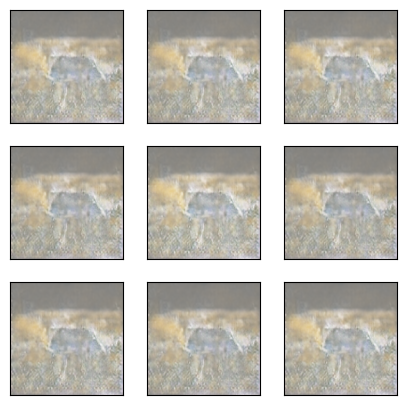

In [ ]:
latent_dim=100
epochs=10000
batchsize=4
# Création du discriminateur
discriminator_model = create_discriminator()
# Création du generateur
generator_model = create_generator()
# Création du GAN
gan_model = create_gan(generator_model, discriminator_model)
# Chargement des données
dataset = load_data('fox')
# train model
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs, batchsize)

ARCHI 2

In [ ]:
latent_dim=100
epochs=10000
batchsize=4
# Création du discriminateur
discriminator_model = create_discriminator_2()
# Création du generateur
generator_model = create_generator_2(latent_dim)
# Création du GAN
gan_model = create_gan(generator_model, discriminator_model)
# Chargement des données
dataset = load_data('fox')
# train model
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs, batchsize)

## GIF


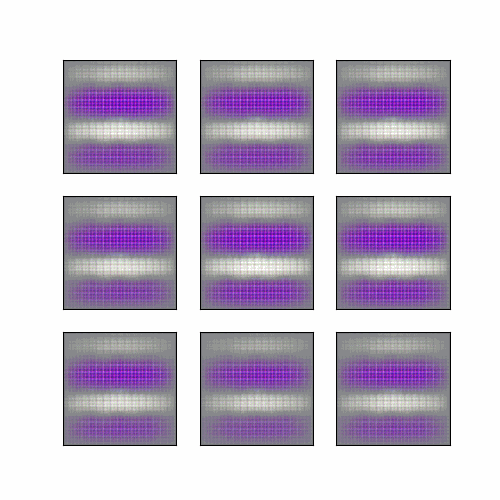

In [ ]:
anim_file = 'Gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('Résultats/GAN/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)

## Transfer learning GAN

In [ ]:
from tensorflow.keras.applications import VGG16

def TL_create_discriminator() :
  base_model = VGG16(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')

  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.25)(x)
  x = Dense(512, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.25)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  model.compile(Lion(learning_rate=.00001), loss='binary_crossentropy', metrics='accuracy')

  return model

In [ ]:
latent_dim=100
epochs=500
batchsize=8
# Création du discriminateur
discriminator_model = TL_create_discriminator()
# Création du generateur
generator_model = create_generator(latent_dim)
# Création du GAN
gan_model = create_gan(generator_model, discriminator_model)
# Chargement des données
dataset = load_data('elephant')
# train model
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs, batchsize)

In [ ]:
evaluate_model(dataset, 1, generator_model, discriminator_model, latent_dim)

In [ ]:
#sauvegarde de 10 images générées par le GAN
latent_dim=100
generated_images = []
noise=tf.random.normal([1,latent_dim])
for i in range(10) :
  image = (generator_model.predict(noise)[0]+1)/2
  generated_images.append(image)

In [ ]:
COLUMNS = 10 # Nombre d'images à afficher
#affichage des images générées
plt.figure(figsize=(15,15))
for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 met les images en BGR et matplotlib lit du RGB
    # il faut donc convertir pour afficher les bonnes couleurs
    generated_images[i] = cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(generated_images[i],cmap=plt.cm.binary)
    plt.xlabel('taille ' + str(generated_images[i].shape))
plt.show()

In [ ]:
#Prédiction des images générées par le GAN sur le modèle avancé
for i in range(10) :
  input_arr = generated_images[i]
  predictions = modeleIDGElephant.predict(input_arr)
print(f"L'image n°{i+1} est prédite comme étant un : ")
if (predictions == 0) :
  print("un autre animal.")
else :
  print("un éléphant.")

## Retraining GAN

https://github.com/bcmi/F2GAN-Few-Shot-Image-Generation

https://github.com/mshahbazi72/cGANTransfer.git

https://keras.io/examples/generative/conditional_gan/